In [1]:
import math
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
date_start = '2005-01-01'
date_end = '2019-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 100
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

symbol     market_datetime    open
0    AEF 2005-01-03 06:00:00  26.780
1    AEP 2005-01-03 06:00:00  34.210
2    ACH 2005-01-03 06:00:00  14.775
3    ABG 2005-01-03 06:00:00  13.800
4     AE 2005-01-03 06:00:00  17.690

### Clean data

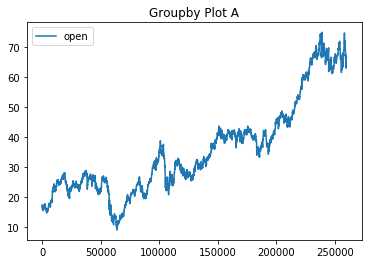

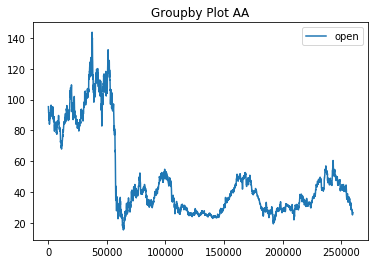

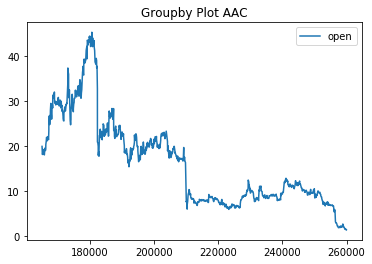

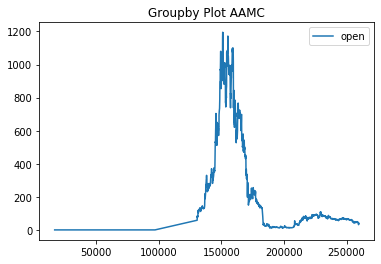

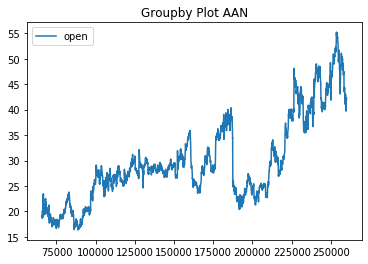

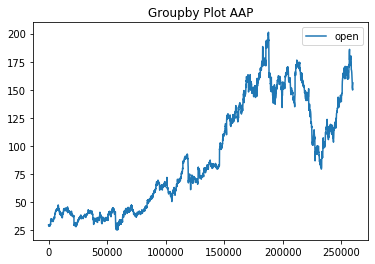

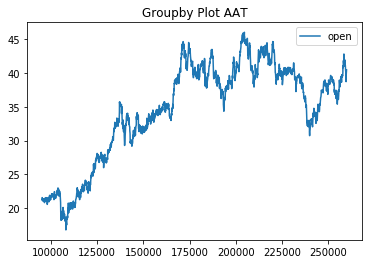

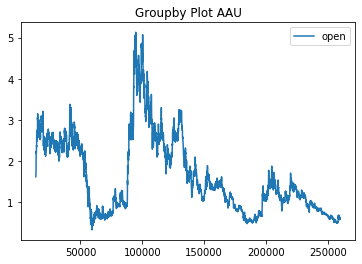

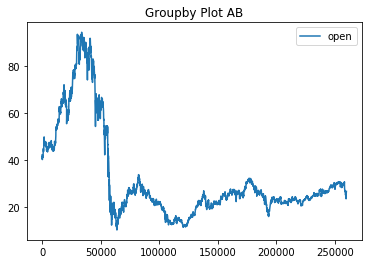

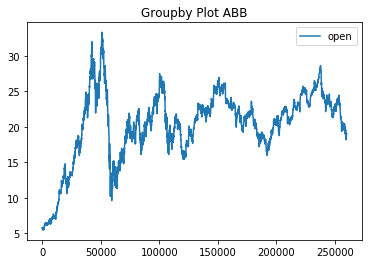

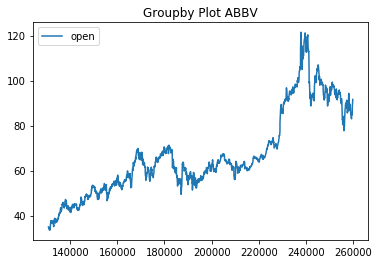

In [3]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

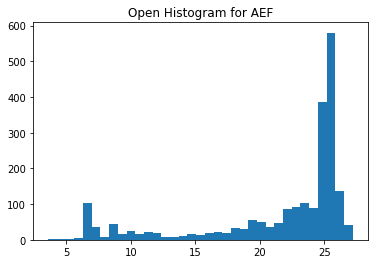

In [4]:
plt.hist(df.loc[df['symbol']==df['symbol'].values[0], 'open'], bins=35)
plt.title('Open Histogram for ' + df['symbol'].values[0])
plt.show()

### Lstm on open data

In [5]:
df['target'] = df['open']

column = 'open'
subset = 'symbol'
window_size = 1000

df['open_min'], df['open_max'] = 0, 0
for val in df[subset].unique():
    df.loc[df[subset] == val, 'open_min'] = df.loc[df[subset] == val, column].rolling(window_size).min()
    df.loc[df[subset] == val, 'open_max'] = df.loc[df[subset] == val, column].rolling(window_size).max()
    df.loc[df[subset] == val, column] = ((df.loc[df[subset] == val, column] - df.loc[df[subset] == val, 'open_min']) 
                                         / (df.loc[df[subset] == val, 'open_max'] - df.loc[df[subset] == val, 'open_min']))

df = df[df['open'].notnull()]

In [6]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

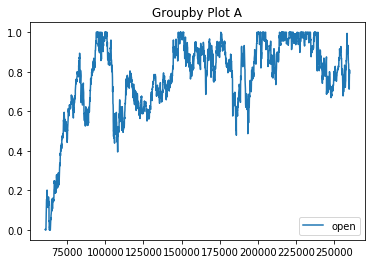

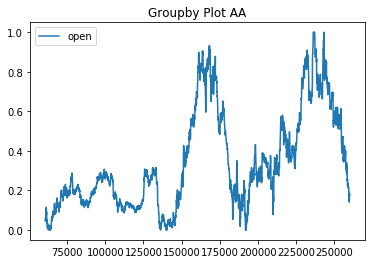

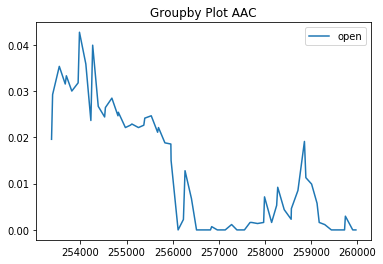

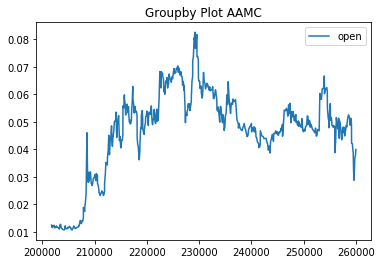

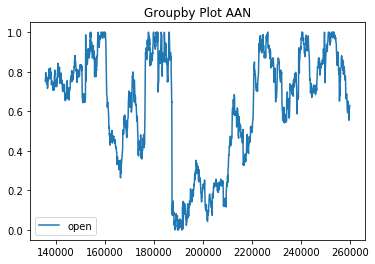

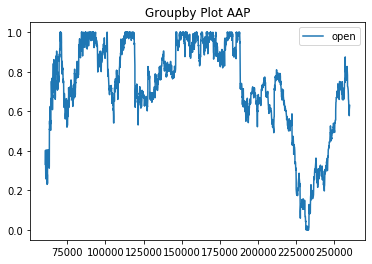

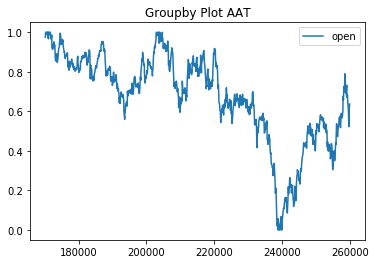

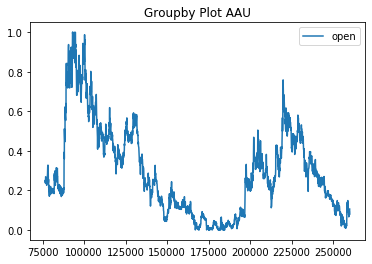

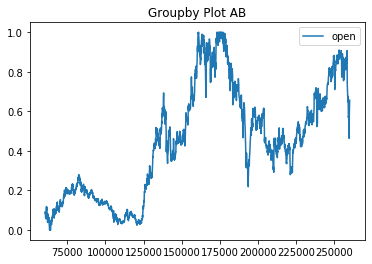

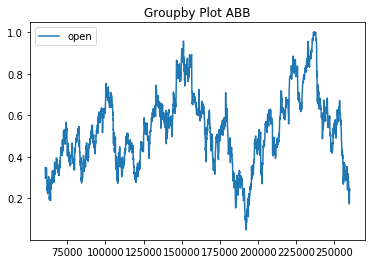

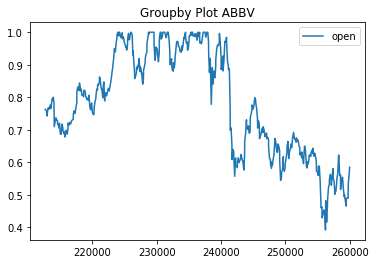

In [7]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

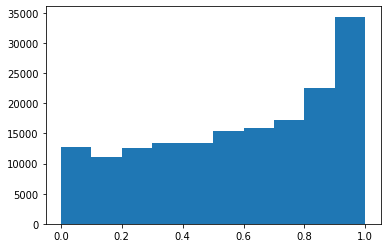

In [8]:
plt.hist(df['open'])
plt.show()

In [9]:
dfs = []
sequence_length=200

for symbol, data in df.groupby('symbol'):
    for offset in range(1, sequence_length, 1):
        data = data.join(data['open'].shift(offset), rsuffix='_' + str(abs(offset)))
    dfs.append(data)

train_test = pd.concat(dfs)
train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')

print(train_test.shape)
train_test.head(10)

(152389, 288)


symbol     market_datetime      open  target  open_min  open_max  \
73628    AES 2009-10-02 05:00:00  0.461824   13.69      4.98    23.840   
73630    AJG 2009-10-02 05:00:00  0.521662   23.74     14.95    31.800   
73589    AEM 2009-10-02 05:00:00  0.749963   63.55     12.95    80.420   
73619    AIN 2009-10-02 05:00:00  0.354601   18.55      5.10    43.030   
73605    ABR 2009-10-02 05:00:00  0.064103    2.58      0.43    33.970   
73623    AIV 2009-10-02 05:00:00  0.146669   13.70      4.96    64.550   
73648    AFB 2009-10-02 05:00:00  0.663821   13.78      7.56    16.930   
73610    ADC 2009-10-02 05:00:00  0.424429   21.12      9.41    37.000   
73585    ABC 2009-10-02 05:00:00  0.590628   21.90     13.77    27.535   
73649    AIZ 2009-10-02 05:00:00  0.222864   30.46     13.11    90.960   

       symbol_A  symbol_AA  symbol_AAC  symbol_AAMC  ...  open_190  open_191  \
73628         0          0           0            0  ...  0.087536  0.075942   
73630         0          0           0            0  ...  0.329474  0.257895   
73589         0          0           0            0  ...  0.557989  0.565336   
73619         0          0           0            0  ...  0.022279  0.021961   
73605         0          0           0            0  ...  0.023581  0.019547   
73623         0          0           0            0  ...  0.053286  0.046536   
73648         0          0           0            0  ...  0.187834  0.182497   
73610         0          0           0            0  ...  0.270011  0.243821   
73585         0          0           0            0  ...  0.284978  0.266844   
73649         0          0           0            0  ...  0.207579  0.182017   

       open_192  open_193  open_194  open_195  open_196  open_197  open_198  \
73628  0.067826  0.062029  0.060290  0.073043  0.075942  0.099130  0.055072   
73630  0.302105  0.259686  0.235602  0.258799  0.275362  0.257764  0.223923   
73589  0.546607  0.529607  0.524852  0.485089  0.527013  0.448062  0.492868   
73619  0.042330  0.042330  0.039784  0.052833  0.060789  0.071292  0.072565   
73605  0.032578  0.039094  0.043438  0.041266  0.040025  0.023891  0.024511   
73623  0.058615  0.052398  0.047247  0.089698  0.094316  0.079574  0.110302   
73648  0.200640  0.178228  0.183565  0.177161  0.152615  0.085379  0.084312   
73610  0.339727  0.309111  0.313537  0.253781  0.216894  0.225009  0.237920   
73585  0.264356  0.260444  0.258311  0.264711  0.277156  0.268267  0.257244   
73649  0.171741  0.170970  0.171869  0.174952  0.180218  0.179319  0.154143   

       open_199  
73628  0.071304  
73630  0.203828  
73589  0.516064  
73619  0.069064  
73605  0.027304  
73623  0.086856  
73648  0.078975  
73610  0.256732  
73585  0.283911  
73649  0.156069  

[10 rows x 288 columns]

In [15]:
data_size = int(round(len(train_test)/2, -2))
print(data_size)
print(int(data_size/50))

76200
1524


Epoch  0 Error:  50240.66015625
Epoch  100 Error:  10015.5205078125
Epoch  200 Error:  4218.3759765625
Epoch  300 Error:  3279.483154296875
Epoch  400 Error:  2804.807861328125
Epoch  500 Error:  2551.475341796875
Epoch  600 Error:  2342.959228515625
Epoch  700 Error:  2201.86669921875
Epoch  800 Error:  2150.0361328125
Epoch  900 Error:  2026.376708984375


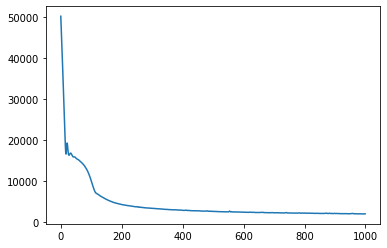

In [16]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'target']

data_size = int(round(len(train_test)/2, -2))
model = nn_utils.TorchLSTM(train_x=train_test.drop(cols_to_ignore, axis=1).head(data_size), 
                           train_y=train_test['open'].head(data_size), 
                           test_x=train_test.drop(cols_to_ignore, axis=1).tail(data_size), 
                           test_y=train_test['open'].tail(data_size),
                           n_layers=2,
                           n_epochs=1000,
                           hidden_shape=300,
                           batch_size=int(data_size/100),
                           dropout=.1,
                           learning_rate=.0001,
                           device='cuda:0')

model.execute()

test_df = model.test_df
model.reset_network()

In [17]:
temp = train_test[cols_to_ignore].tail(data_size).reset_index(drop=True)
test_df = test_df.join(temp)
test_df.head()

symbol_A  symbol_AA  symbol_AAC  symbol_AAMC  symbol_AAN  symbol_AAP  \
0       0.0        0.0         0.0          0.0         0.0         0.0   
1       0.0        0.0         0.0          0.0         0.0         0.0   
2       0.0        0.0         0.0          0.0         0.0         0.0   
3       0.0        0.0         0.0          0.0         0.0         0.0   
4       0.0        0.0         0.0          0.0         0.0         0.0   

   symbol_AAT  symbol_AAU  symbol_AB  symbol_ABB  ...  open_198  open_199  \
0         0.0         0.0        0.0         0.0  ...  0.235772  0.235772   
1         0.0         0.0        0.0         0.0  ...  0.961712  0.941441   
2         0.0         0.0        0.0         0.0  ...  0.913524  0.910923   
3         0.0         0.0        0.0         0.0  ...  0.075676  0.077027   
4         0.0         0.0        0.0         0.0  ...  0.773216  0.790811   

    actuals  prediction  symbol     market_datetime      open  open_min  \
0  0.329849    0.267716    ACCO 2014-10-24 05:00:00  0.329849      4.38   
1  0.954693    0.906040     AEE 2014-10-24 05:00:00  0.954693     26.36   
2  0.774083    0.722250     AGO 2014-10-24 05:00:00  0.774083      9.26   
3  0.093369    0.062961     AGD 2014-10-24 05:00:00  0.093369      8.89   
4  0.737505    0.763265     AGM 2014-10-24 05:00:00  0.737505     13.04   

   open_max  target  
0     12.99    7.22  
1     41.81   41.11  
2     26.70   22.76  
3     16.28    9.58  
4     37.65   31.19  

[5 rows x 290 columns]

In [18]:
test_df['prediction_mapped'] = (test_df['prediction'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['actuals_mapped'] = (test_df['actuals'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['errors'] = test_df['prediction'] - test_df['actuals']

test_df.head(10)

symbol_A  symbol_AA  symbol_AAC  symbol_AAMC  symbol_AAN  symbol_AAP  \
0       0.0        0.0         0.0          0.0         0.0         0.0   
1       0.0        0.0         0.0          0.0         0.0         0.0   
2       0.0        0.0         0.0          0.0         0.0         0.0   
3       0.0        0.0         0.0          0.0         0.0         0.0   
4       0.0        0.0         0.0          0.0         0.0         0.0   
5       0.0        0.0         0.0          0.0         0.0         0.0   
6       0.0        0.0         0.0          0.0         0.0         0.0   
7       0.0        0.0         0.0          0.0         0.0         0.0   
8       0.0        0.0         0.0          0.0         0.0         0.0   
9       0.0        0.0         0.0          0.0         0.0         0.0   

   symbol_AAT  symbol_AAU  symbol_AB  symbol_ABB  ...  prediction  symbol  \
0         0.0         0.0        0.0         0.0  ...    0.267716    ACCO   
1         0.0         0.0        0.0         0.0  ...    0.906040     AEE   
2         0.0         0.0        0.0         0.0  ...    0.722250     AGO   
3         0.0         0.0        0.0         0.0  ...    0.062961     AGD   
4         0.0         0.0        0.0         0.0  ...    0.763265     AGM   
5         0.0         0.0        0.0         0.0  ...    0.698634     ABM   
6         0.0         0.0        0.0         0.0  ...    0.913620     ACU   
7         0.0         0.0        0.0         0.0  ...    0.871570     ABT   
8         0.0         0.0        0.0         0.0  ...    0.824309     AJG   
9         0.0         0.0        0.0         0.0  ...    0.695587     AGX   

      market_datetime      open   open_min  open_max  target  \
0 2014-10-24 05:00:00  0.329849   4.380000    12.990    7.22   
1 2014-10-24 05:00:00  0.954693  26.360000    41.810   41.11   
2 2014-10-24 05:00:00  0.774083   9.260000    26.700   22.76   
3 2014-10-24 05:00:00  0.093369   8.890000    16.280    9.58   
4 2014-10-24 05:00:00  0.737505  13.040000    37.650   31.19   
5 2014-10-24 05:00:00  0.764045  17.540000    29.110   26.38   
6 2014-10-24 05:00:00  0.976274   8.880000    17.689   17.48   
7 2014-10-24 05:00:00  0.927490  21.618259    43.960   42.34   
8 2014-10-24 05:00:00  0.838247  24.960000    49.380   45.43   
9 2014-10-24 05:00:00  0.729697   8.110000    40.740   31.92   

   prediction_mapped  actuals_mapped    errors  
0           6.685031        7.220000 -0.062133  
1          40.358324       41.110000 -0.048652  
2          21.856031       22.760000 -0.051833  
3           9.355285        9.580000 -0.030408  
4          31.823952       31.190000  0.025760  
5          25.623198       26.380000 -0.065411  
6          16.928075       17.480000 -0.062655  
7          41.090659       42.340000 -0.055920  
8          45.089636       45.430001 -0.013938  
9          30.807015       31.919999 -0.034109  

[10 rows x 293 columns]

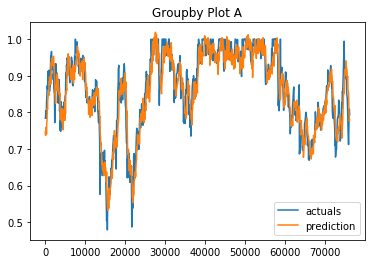

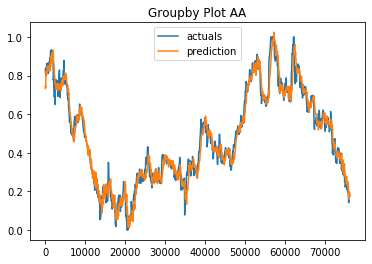

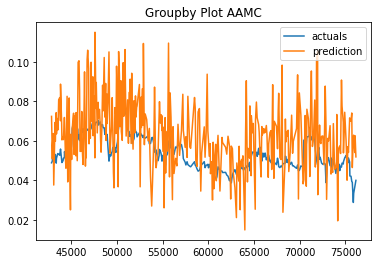

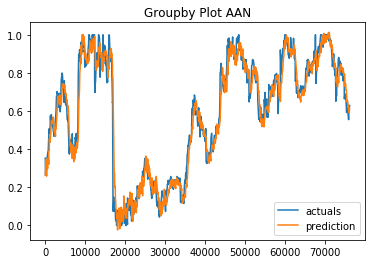

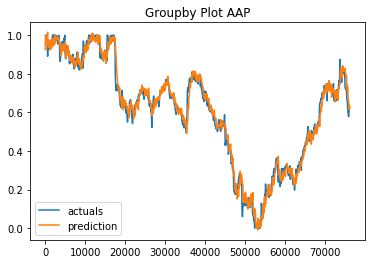

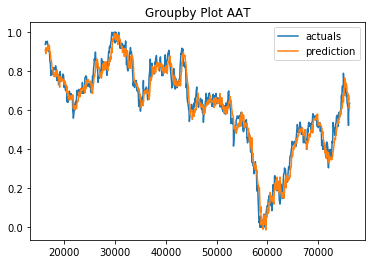

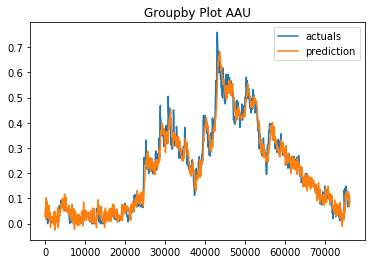

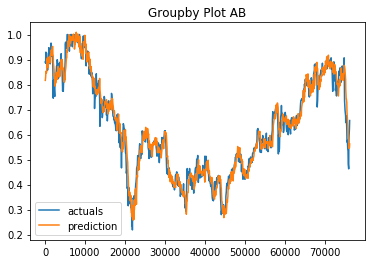

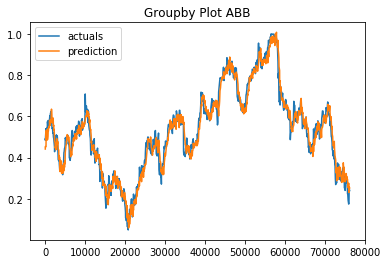

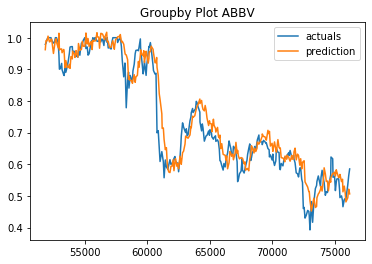

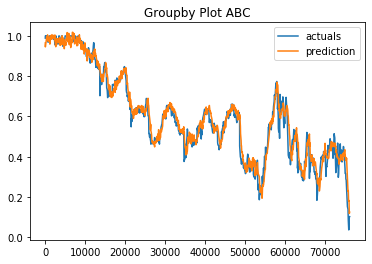

In [19]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['actuals', 'prediction'])

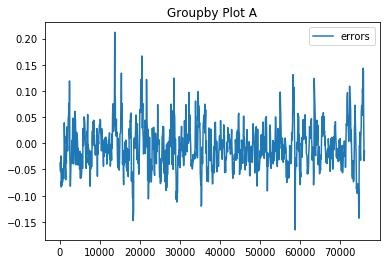

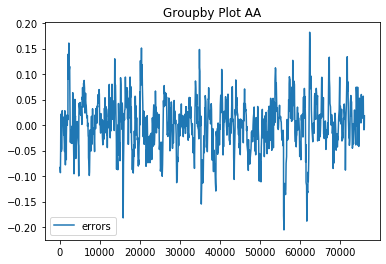

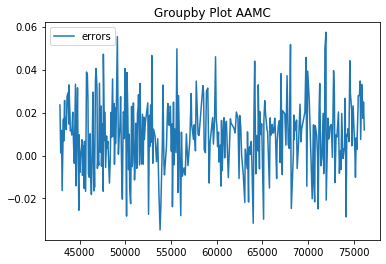

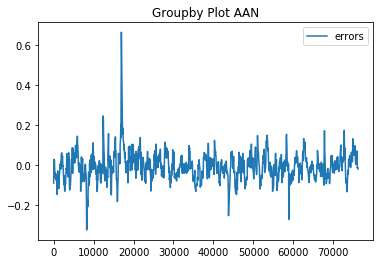

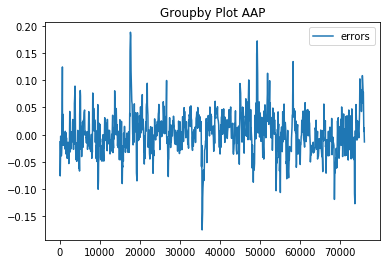

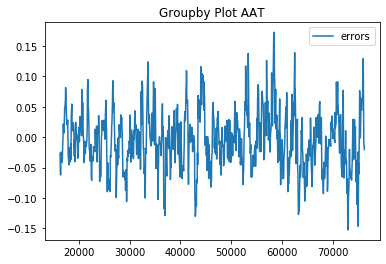

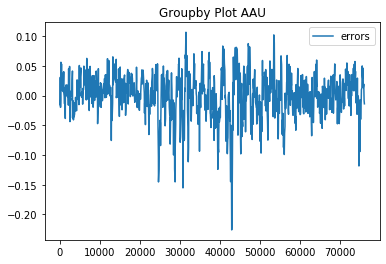

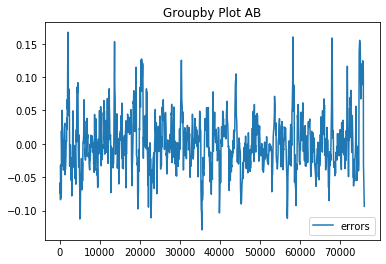

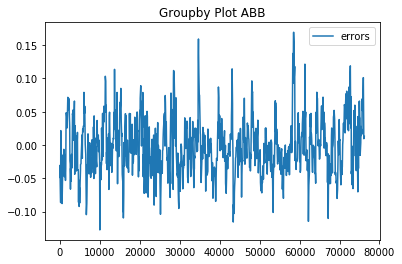

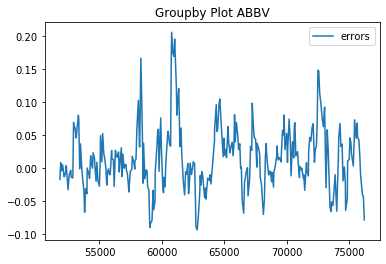

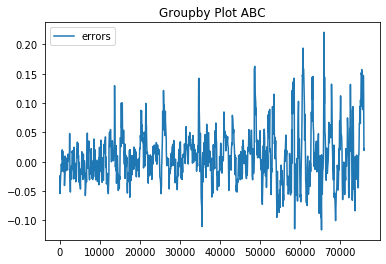

In [20]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['errors'])

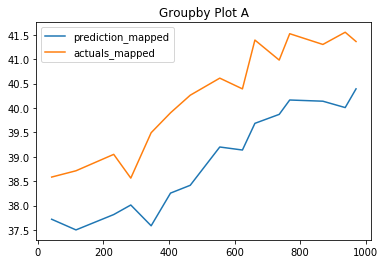

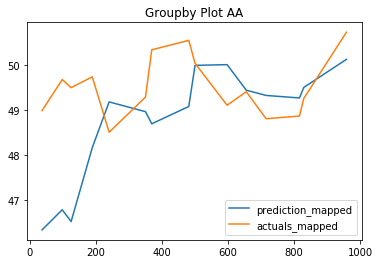

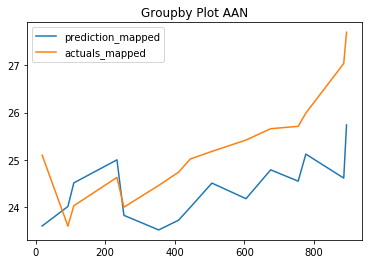

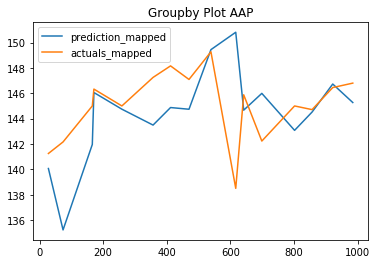

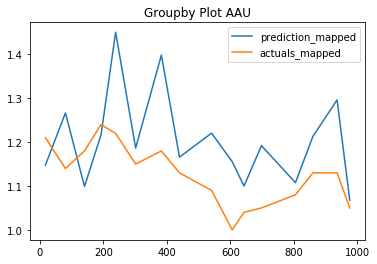

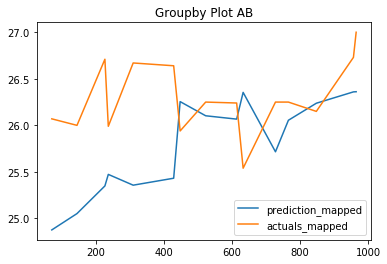

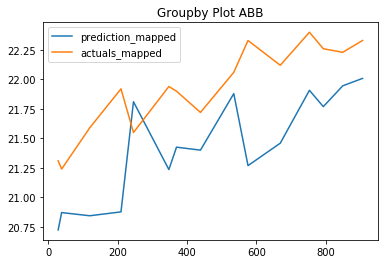

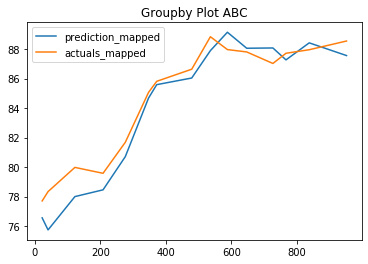

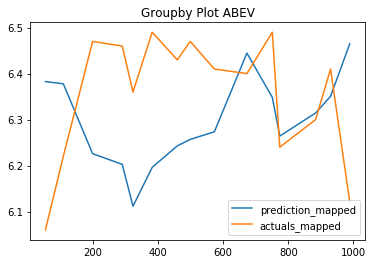

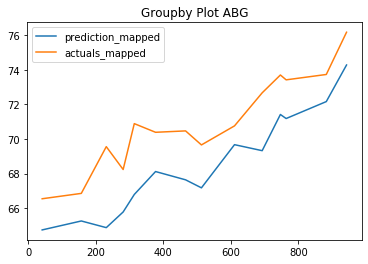

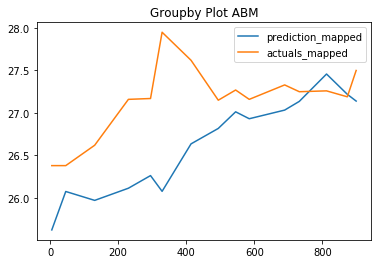

In [21]:
cluster_utils.plot_groupby(test_df.head(1000), 'symbol', lines=['prediction_mapped', 'actuals_mapped'])

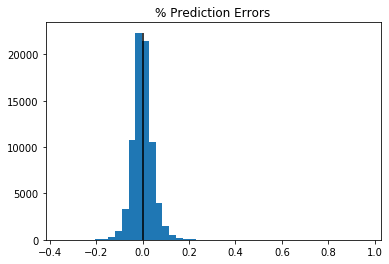

In [22]:
plt.title('% Prediction Errors')
plot = plt.hist(test_df['errors'], bins=45)
plt.vlines(0, ymin=0, ymax=plot[0].max())
plt.show()